<a href="https://colab.research.google.com/github/Andron00e/CBM_Optim/blob/main/cifar100_concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install open_clip_torch
!pip install -U sentence-transformers
!pip install openai-clip
!pip install pytorchcv
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=248ebdacffd6b2c5e953e689fa349551df35c0a9fcdbc69e5897de2c18fc333d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd

In [4]:
import open_clip
import clip
from torchvision.datasets import CIFAR10, CIFAR100
from open_clip import tokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sentence_transformers import SentenceTransformer
import requests
import json
import math
import random
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
LABEL_FILES = {"cifar100":"data/cifar100_classes.txt"}
LIMIT = 200
RELATIONS = ["HasA", "IsA", "PartOf", "HasProperty", "MadeOf", "AtLocation"]

CLASS_SIM_CUTOFF = 0.85
OTHER_SIM_CUTOFF = 0.9
MAX_LEN = 30
PRINT_PROB = 0.2

dataset = "cifar100"
save_name = 'data/conceptnet_{}_filtered_new.txt'.format(dataset)
# was data/conceptnet_{}_filtered_new.txt

### preprocess functions

In [7]:
def get_init_conceptnet(classes, limit=200, relations=["HasA", "IsA", "PartOf", "HasProperty", "MadeOf", "AtLocation"]):
    concepts = set()

    for cls in tqdm(classes):
        words = cls.replace(',', '').split(' ')
        for word in words:
            obj = requests.get('http://api.conceptnet.io/c/en/{}?limit={}'.format(word, limit)).json()
            obj.keys()
            for dicti in obj['edges']:
                rel = dicti['rel']['label']
                try:
                    if dicti['start']['language'] != 'en' or dicti['end']['language'] != 'en':
                        continue
                except(KeyError):
                    continue

                if rel in relations:
                    if rel in ["IsA"]:
                        concepts.add(dicti['end']['label'])
                    else:
                        concepts.add(dicti['start']['label'])
                        concepts.add(dicti['end']['label'])
    return concepts

In [8]:
def _clip_dot_prods(list1, list2, device="cuda", clip_name="ViT-B/16", batch_size=500):
    "Returns: numpy array with dot products"
    clip_model, _ = clip.load(clip_name, device=device)
    text1 = clip.tokenize(list1).to(device)
    text2 = clip.tokenize(list2).to(device)

    features1 = []
    with torch.no_grad():
        for i in range(math.ceil(len(text1)/batch_size)):
            features1.append(clip_model.encode_text(text1[batch_size*i:batch_size*(i+1)]))
        features1 = torch.cat(features1, dim=0)
        features1 /= features1.norm(dim=1, keepdim=True)

    features2 = []
    with torch.no_grad():
        for i in range(math.ceil(len(text2)/batch_size)):
            features2.append(clip_model.encode_text(text2[batch_size*i:batch_size*(i+1)]))
        features2 = torch.cat(features2, dim=0)
        features2 /= features2.norm(dim=1, keepdim=True)

    dot_prods = features1 @ features2.T
    return dot_prods.cpu().numpy()

In [9]:
def filter_too_similar_to_cls(concepts, classes, sim_cutoff, device="cuda", print_prob=0):
    #first check simple text matches
    print(len(concepts))
    concepts = list(concepts)
    concepts = sorted(concepts)

    for cls in classes:
        for prefix in ["", "a ", "A ", "an ", "An ", "the ", "The "]:
            try:
                concepts.remove(prefix+cls)
                if random.random()<print_prob:
                    print("Class:{} - Deleting {}".format(cls, prefix+cls))
            except(ValueError):
                pass
        try:
            concepts.remove(cls.upper())
        except(ValueError):
            pass
        try:
            concepts.remove(cls[0].upper()+cls[1:])
        except(ValueError):
            pass
    print(len(concepts))

    mpnet_model = SentenceTransformer('all-mpnet-base-v2')
    class_features_m = mpnet_model.encode(classes)
    concept_features_m = mpnet_model.encode(concepts)
    dot_prods_m = class_features_m @ concept_features_m.T
    dot_prods_c = _clip_dot_prods(classes, concepts)
    #weighted since mpnet has highger variance
    dot_prods = (dot_prods_m + 3*dot_prods_c)/4

    to_delete = []
    for i in range(len(classes)):
        for j in range(len(concepts)):
            prod = dot_prods[i,j]
            if prod >= sim_cutoff and i!=j:
                if j not in to_delete:
                    to_delete.append(j)
                    if random.random()<print_prob:
                        print("Class:{} - Concept:{}, sim:{:.3f} - Deleting {}".format(classes[i], concepts[j], dot_prods[i,j], concepts[j]))
                        print("".format(concepts[j]))

    to_delete = sorted(to_delete)[::-1]

    for item in to_delete:
        concepts.pop(item)
    print(len(concepts))
    return concepts

In [10]:
def filter_too_similar(concepts, sim_cutoff, device="cuda", print_prob=0):

    mpnet_model = SentenceTransformer('all-mpnet-base-v2')
    concept_features = mpnet_model.encode(concepts)

    dot_prods_m = concept_features @ concept_features.T
    dot_prods_c = _clip_dot_prods(concepts, concepts)

    dot_prods = (dot_prods_m + 3*dot_prods_c)/4

    to_delete = []
    for i in range(len(concepts)):
        for j in range(len(concepts)):
            prod = dot_prods[i,j]
            if prod >= sim_cutoff and i!=j:
                if i not in to_delete and j not in to_delete:
                    to_print = random.random() < print_prob
                    #Deletes the concept with lower average similarity to other concepts - idea is to keep more general concepts
                    if np.sum(dot_prods[i]) < np.sum(dot_prods[j]):
                        to_delete.append(i)
                        if to_print:
                            print("{} - {} , sim:{:.4f} - Deleting {}".format(concepts[i], concepts[j], dot_prods[i,j], concepts[i]))
                    else:
                        to_delete.append(j)
                        if to_print:
                            print("{} - {} , sim:{:.4f} - Deleting {}".format(concepts[i], concepts[j], dot_prods[i,j], concepts[j]))

    to_delete = sorted(to_delete)[::-1]
    for item in to_delete:
        concepts.pop(item)
    print(len(concepts))
    return concepts

In [11]:
def remove_too_long(concepts, max_len, print_prob=0):
    new_concepts = []
    for concept in concepts:
        if len(concept) <= max_len:
            new_concepts.append(concept)
        else:
            if random.random()<print_prob:
                print(len(concept), concept)
    print(len(concepts), len(new_concepts))
    return new_concepts

In [29]:
cls_file = LABEL_FILES[dataset]

with open(cls_file, 'r') as f:
    classes = f.read().split('\n')

In [13]:
def preprocess_concepts(CLASS_SIM_CUTOFF, OTHER_SIM_CUTOFF, MAX_LEN, PRINT_PROB):
  concepts = get_init_conceptnet(classes, LIMIT, RELATIONS)
  concepts = remove_too_long(concepts, MAX_LEN, PRINT_PROB)
  concepts = filter_too_similar_to_cls(concepts, classes, CLASS_SIM_CUTOFF, print_prob=PRINT_PROB)
  concepts = filter_too_similar(concepts, OTHER_SIM_CUTOFF, print_prob=PRINT_PROB)
  return concepts

### inference

In [ ]:
concepts = get_init_conceptnet(classes, LIMIT, RELATIONS)
concepts = remove_too_long(concepts, MAX_LEN, PRINT_PROB)
concepts = filter_too_similar_to_cls(concepts, classes, CLASS_SIM_CUTOFF, print_prob=PRINT_PROB)
concepts = filter_too_similar(concepts, OTHER_SIM_CUTOFF, print_prob=PRINT_PROB)

In [34]:
with open(save_name, "w") as f:
    f.write(concepts[0])
    for concept in concepts[1:]:
        f.write("\n" + concept)

In [21]:
'''
from contextlib import redirect_stdout

with open(save_name, "w") as f:
  with redirect_stdout(f):
    preprocess_concepts(CLASS_SIM_CUTOFF, OTHER_SIM_CUTOFF, MAX_LEN, PRINT_PROB)
'''

100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


In [22]:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai') # ViT-B-16 openai

In [23]:
clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


In [24]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:05<00:00, 29587335.09it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


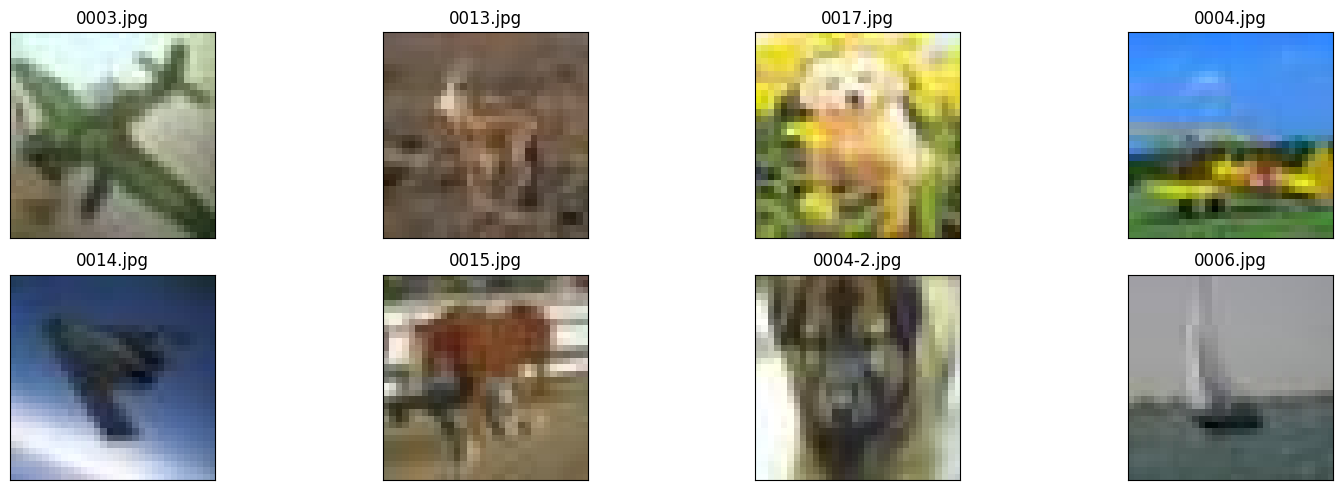

In [25]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/content/") if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    images.append(preprocess(image))
    original_images.append(image)

plt.tight_layout()

In [26]:
image_input = torch.tensor(np.stack(images))

with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()

image_features /= image_features.norm(dim=-1, keepdim=True)

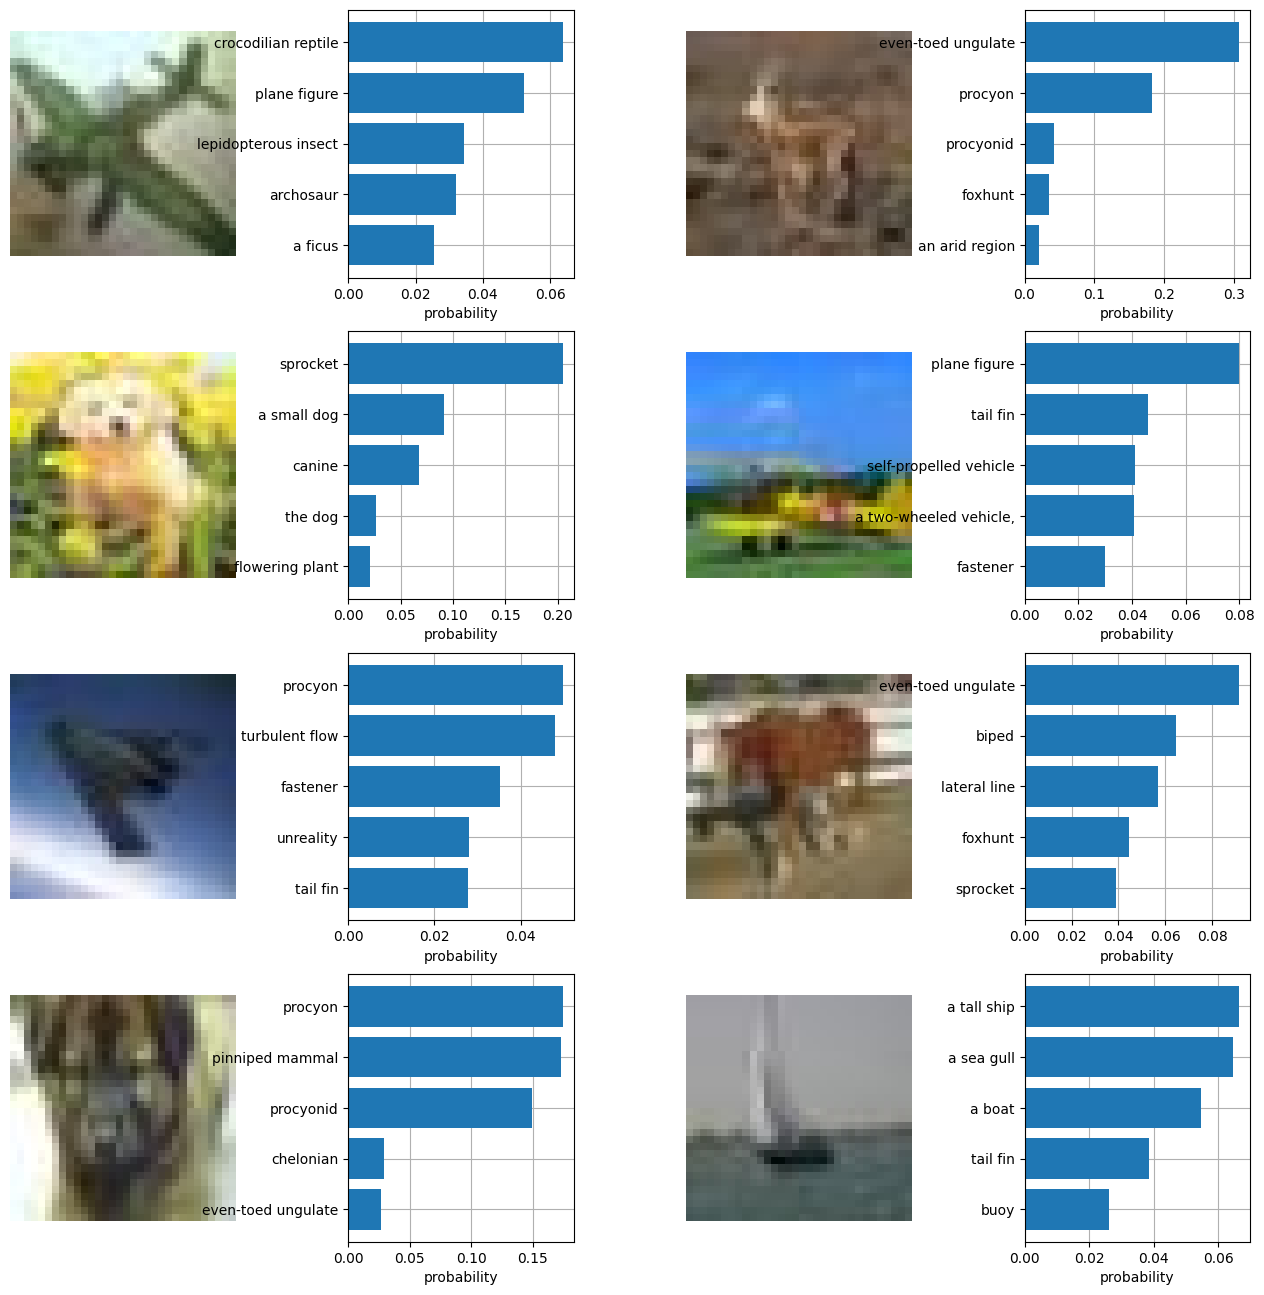

In [35]:
text_descriptions = []

with open("data/conceptnet_cifar100_filtered_new.txt", "r") as file:
    for line in file:
        text_descriptions.append(line.strip())
text_tokens = tokenizer.tokenize(text_descriptions)

with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()